## The next cell will get a ~65 MB data file 'sequence.index', you only need to run the cell once

In [1]:
!rm sequence.index 2>/dev/null
!wget -nd ftp://ftp.1000genomes.ebi.ac.uk/vol1/ftp/historical_data/former_toplevel/sequence.index -O sequence.index

--2016-02-05 15:45:59--  ftp://ftp.1000genomes.ebi.ac.uk/vol1/ftp/historical_data/former_toplevel/sequence.index
           => 'sequence.index'
Resolving ftp.1000genomes.ebi.ac.uk (ftp.1000genomes.ebi.ac.uk)... 193.62.192.8
Connecting to ftp.1000genomes.ebi.ac.uk (ftp.1000genomes.ebi.ac.uk)|193.62.192.8|:21... connected.
Logging in as anonymous ... Logged in!
==> SYST ... done.    ==> PWD ... done.
==> TYPE I ... done.  ==> CWD (1) /vol1/ftp/historical_data/former_toplevel ... done.
==> SIZE sequence.index ... 67069489
==> PASV ... done.    ==> RETR sequence.index ... done.
Length: 67069489 (64M) (unauthoritative)

sequence.index      100%[=====================>]  63.96M   562KB/s   in 2m 31s 

2016-02-05 15:48:34 (434 KB/s) - 'sequence.index' saved [67069489]



# Interfacing with R

In [1]:
import os

from IPython.display import Image

import rpy2.robjects as robjects
import rpy2.robjects.lib.ggplot2 as ggplot2
from rpy2.robjects.functions import SignatureTranslatedFunction

import pandas as pd
import pandas.rpy.common as pd_common

/root/miniconda/lib/python3.4/importlib/_bootstrap.py:321: FutureWarning: The pandas.rpy module is deprecated and will be removed in a future version. We refer to external packages like rpy2. 
See here for a guide on how to port your code to rpy2: http://pandas.pydata.org/pandas-docs/stable/r_interface.html
  return f(*args, **kwds)


In [2]:
read_delim = robjects.r('read.delim')
seq_data = read_delim('sequence.index', header=True, stringsAsFactors=False)
#In R:
#  seq.data <- read.delim('sequence.index', header=TRUE, stringsAsFactors=FALSE)

In [3]:
print('This data frame has %d columns and %d rows' % (seq_data.ncol, seq_data.nrow))
print(seq_data.colnames)
#In R:
#  print(colnames(seq.data))
#  print(nrow(seq.data))
#  print(ncol(seq.data))

print('Columns in Python %d ' % robjects.r.ncol(seq_data)[0])

#access some functions
as_integer = robjects.r('as.integer')
match = robjects.r.match

my_col = match('READ_COUNT', seq_data.colnames)[0] # Vector returned
print('Type of read count before as.integer: %s' % seq_data[my_col - 1].rclass[0])
seq_data[my_col - 1] = as_integer(seq_data[my_col - 1])
print('Type of read count after as.integer: %s' % seq_data[my_col - 1].rclass[0])

my_col = match('BASE_COUNT', seq_data.colnames)[0] # Vector returned
seq_data[my_col - 1] = as_integer(seq_data[my_col - 1])

my_col = match('CENTER_NAME', seq_data.colnames)[0]
seq_data[my_col - 1] = robjects.r.toupper(seq_data[my_col - 1])
robjects.r.assign('seq.data', seq_data)
robjects.r('print(c("Column names in R: ",colnames(seq.data)))')

robjects.r('seq.data <- seq.data[seq.data$WITHDRAWN==0, ]')
#Lets remove all withdrawn sequences

robjects.r("seq.data <- seq.data[, c('STUDY_ID', 'STUDY_NAME', 'CENTER_NAME', 'SAMPLE_ID', 'SAMPLE_NAME', 'POPULATION', 'INSTRUMENT_PLATFORM', 'LIBRARY_LAYOUT', 'PAIRED_FASTQ', 'READ_COUNT', 'BASE_COUNT', 'ANALYSIS_GROUP')]")
#Lets shorten the dataframe

#Population as factor
robjects.r('seq.data$POPULATION <- as.factor(seq.data$POPULATION)')

This data frame has 26 columns and 187720 rows
 [1] "FASTQ_FILE"          "MD5"                 "RUN_ID"             
 [4] "STUDY_ID"            "STUDY_NAME"          "CENTER_NAME"        
 [7] "SUBMISSION_ID"       "SUBMISSION_DATE"     "SAMPLE_ID"          
[10] "SAMPLE_NAME"         "POPULATION"          "EXPERIMENT_ID"      
[13] "INSTRUMENT_PLATFORM" "INSTRUMENT_MODEL"    "LIBRARY_NAME"       
[16] "RUN_NAME"            "RUN_BLOCK_NAME"      "INSERT_SIZE"        
[19] "LIBRARY_LAYOUT"      "PAIRED_FASTQ"        "WITHDRAWN"          
[22] "WITHDRAWN_DATE"      "COMMENT"             "READ_COUNT"         
[25] "BASE_COUNT"          "ANALYSIS_GROUP"     

Columns in Python 26 
Type of read count before as.integer: character
Type of read count after as.integer: integer
 [1]
 "Column names in R: "
 "FASTQ_FILE"         
 "MD5"                


 [4]
 "RUN_ID"             
 "STUDY_ID"           
 "STUDY_NAME"         


 [7]
 "CENTER_NAME"        
 "SUBMISSION_ID"      
 "SUBMISSION_DATE

<FactorVector - Python:0x7fa7bd3d4208 / R:0xf478c60>
[      27,       27,       27, ...,       25,       25,       25]

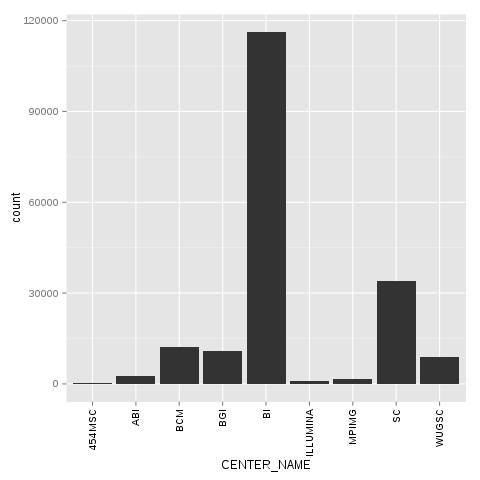

In [4]:
ggplot2.theme = SignatureTranslatedFunction(ggplot2.theme,
                                            init_prm_translate = {'axis_text_x': 'axis.text.x'})
bar = ggplot2.ggplot(seq_data) + ggplot2.geom_bar() + ggplot2.aes_string(x='CENTER_NAME') + ggplot2.theme(axis_text_x=ggplot2.element_text(angle=90, hjust=1))
robjects.r.png('out.png')
bar.plot()
dev_off = robjects.r('dev.off')
dev_off()
Image(filename='out.png')

In [5]:
#Get Yoruba and CEU
robjects.r('yri_ceu <- seq.data[seq.data$POPULATION %in% c("YRI", "CEU") & seq.data$BASE_COUNT < 2E9 & seq.data$READ_COUNT < 3E7, ]')
yri_ceu = robjects.r('yri_ceu')

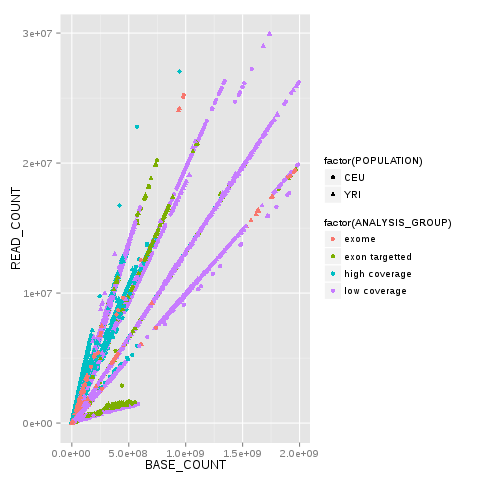

In [6]:
scatter = ggplot2.ggplot(yri_ceu) + ggplot2.aes_string(x='BASE_COUNT', y='READ_COUNT', shape='factor(POPULATION)', col='factor(ANALYSIS_GROUP)') + ggplot2.geom_point()
robjects.r.png('out.png')
scatter.plot()
dev_off = robjects.r('dev.off')
dev_off()
Image(filename='out.png')

In [7]:
pd_yri_ceu = pd_common.load_data('yri_ceu')
print(type(pd_yri_ceu))
pd_yri_ceu

<class 'pandas.core.frame.DataFrame'>


,STUDY_ID,STUDY_NAME,CENTER_NAME,SAMPLE_ID,SAMPLE_NAME,POPULATION,INSTRUMENT_PLATFORM,LIBRARY_LAYOUT,PAIRED_FASTQ,READ_COUNT,BASE_COUNT,ANALYSIS_GROUP
1,SRP000032,1000Genomes Project Pilot 2,BGI,SRS000212,NA19238,YRI,ILLUMINA,SINGLE,,9280498,334097928,high coverage
2,SRP000032,1000Genomes Project Pilot 2,BGI,SRS000212,NA19238,YRI,ILLUMINA,SINGLE,,9571982,344591352,high coverage
3,SRP000032,1000Genomes Project Pilot 2,BGI,SRS000214,NA19240,YRI,ILLUMINA,PAIRED,,149044,5365584,high coverage
4,SRP000032,1000Genomes Project Pilot 2,BGI,SRS000214,NA19240,YRI,ILLUMINA,PAIRED,data/NA19240/sequence_read/ERR000020_2.filt.fa...,2057690,74076840,high coverage
5,SRP000032,1000Genomes Project Pilot 2,BGI,SRS000214,NA19240,YRI,ILLUMINA,PAIRED,data/NA19240/sequence_read/ERR000020_1.filt.fa...,2057690,74076840,high coverage
6,SRP000032,1000Genomes Project Pilot 2,BGI,SRS000212,NA19238,YRI,ILLUMINA,SINGLE,,9388168,337974048,high coverage
7,SRP000032,1000Genomes Project Pilot 2,BGI,SRS000212,NA19238,YRI,ILLUMINA,SINGLE,,7762958,279466488,high coverage
8,SRP000032,1000Genomes Project Pilot 2,BGI,SRS000212,NA19238,YRI,ILLUMINA,SINGLE,,9625450,385018000,high coverage
9,SRP000032,1000Genomes Project Pilot 2,BGI,SRS000212,NA19238,YRI,ILLUMINA,SINGLE,,8808642,317111112,high coverage
10,SRP000032,1000Genomes Project Pilot 2,BGI,SRS000214,NA19240,YRI,ILLUMINA,PAIRED,,15187,683415,high coverage


In [8]:
del pd_yri_ceu['PAIRED_FASTQ']
no_paired = pd_common.convert_to_r_dataframe(pd_yri_ceu)
robjects.r.assign('no.paired', no_paired)
robjects.r("print(colnames(no.paired))")

 [1]
 "STUDY_ID"           
 "STUDY_NAME"         
 "CENTER_NAME"        


 [4]
 "SAMPLE_ID"          
 "SAMPLE_NAME"        
 "POPULATION"         


 [7]
 "INSTRUMENT_PLATFORM"
 "LIBRARY_LAYOUT"     
 "READ_COUNT"         


[10]
 "BASE_COUNT"         
 "ANALYSIS_GROUP"     




<StrVector - Python:0x7fa7b7c84ac8 / R:0x1061f248>
['STUD..., 'STUD..., 'CENT..., ..., 'READ..., 'BASE..., 'ANAL...]